<a href="https://colab.research.google.com/github/abinayaa123/ME592/blob/main/ME592_ESHM_HW4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ME592 HW04: Engineering Systems Health Monitoring

April 18, 2022

Casey Robinson (Task 1), Henry Croll (Task 1), Abinayaa Dhanagopal (Task 2), Nianyu Jiang (Task 2), Timilehin Ayanlade (Task 2)

Homework was divided by task, with each team member working on the entirety of that task, then collaborating/combining with the other team member(s) assigned to that task. Ultimately, entire team reviewed code for full homework.

In [ ]:
!pip install mat73

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import mat73
import numpy as np
from PIL import Image as im
import cv2
from google.colab.patches import cv2_imshow

In [ ]:
#Abinayaa's loadmat:
#combustion_img_13 = mat73.loadmat('/content/drive/MyDrive/ME592/Aditya_data/combustion_img_13.mat')

#Casey's loadmat:
combustion_img_13 = mat73.loadmat('/content/drive/My Drive/ME592/combustion_img_13.mat')

In [ ]:
%cd /content/drive/MyDrive/ME592/
!ls

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592
'3D CNN files'	 Aditya_data  'Assignment 1'  'Assignment 2'   Models


# Preprocessing

In [ ]:
test_set_x = combustion_img_13['test_set_x']
# (18000,25000) - appears to be 18000 images
test_set_y = combustion_img_13['test_set_y']
# (18000,) - single array of 18000 entrys; assume stable = 1, unstable = 0
train_set_x = combustion_img_13['train_set_x']
# (54000,25000) - appears to be 54000 images
train_set_y = combustion_img_13['train_set_y']
# (54000,) - single array of 54000 entrys; assume stable = 1, unstable = 0
valid_set_x = combustion_img_13['valid_set_x']
# (9000,25000) - appears to be 9000 images
valid_set_y = combustion_img_13['valid_set_y']
# (9000,) - single array of 9000 entrys; assume stable = 1, unstable = 0

In [ ]:
# Create arrays of images
# the array should be (XXX, 250, 100, 1)
# Each image is a 25000 length array. Since the images are 250 x 100, it is
# assumed that the images are grayscale. 
# Resource: https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/?msclkid=66a28f83b67911ec9454a31c9393e7bb

# Define a function to do this
def create_image(array):

  # Reshape array into desired resolution
  array = np.reshape(array, (250,100))
  return array

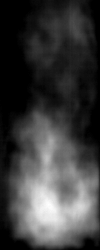

In [ ]:
# Test to make sure the image looks correct
array = np.reshape(test_set_x[1], (250,100))
image = im.fromarray(array)
image

In [ ]:
# Create arrays of images (x arrays)
# Initialize arrays, each should be (XXX, 250, 100, 1)
# Use float32 to save RAM

test_x = np.float32(np.empty((len(test_set_x),250,100)))
valid_x = np.float32(np.empty((len(valid_set_x),250,100)))
train_x = np.float32(np.empty((len(train_set_x),250,100)))

In [ ]:
# reshape arrays
for k in range(len(test_set_x)):
 array = create_image(test_set_x[k])
 test_x[k] = array

for k in range(len(valid_set_x)):
 array = create_image(valid_set_x[k])
 valid_x[k] = array

for k in range(len(train_set_x)):
 array = create_image(train_set_x[k])
 train_x[k] = array

test_y=test_set_y
valid_y=valid_set_y
train_y=train_set_y

In [ ]:
# check array shapes to make sure as expected
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(18000, 250, 100)
(18000,)
(54000, 250, 100)
(54000,)
(9000, 250, 100)
(9000,)


# Task 1 Complete Dataset and 2D CNN Modeling

In [ ]:
import torch as th
import torchvision
import torchvision.transforms as transforms

In [ ]:
# Seed the random generator to have reproducible results to make comparing 
# models easier
seed = 42
np.random.seed(seed)
th.manual_seed(seed)

if th.cuda.is_available():
  # Make CuDNN Determinist
  th.backends.cudnn.deterministic = True
  th.cuda.manual_seed(seed)

# Define default device, we should use the GPU (cuda) if available
device = th.device("cuda" if th.cuda.is_available() else "cpu")

In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(18000, 250, 100)
(18000,)
(54000, 250, 100)
(54000,)
(9000, 250, 100)
(9000,)


In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv2D(50, (5, 2), strides=(5, 2),padding="same",activation='relu', input_shape=(250, 100, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(100, (2, 2), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(50, activation='relu'),
            tf.keras.layers.Dense(25)                
          ])
  #adam = keras.optimizers.Adam(learning_rate=0.001)
  #model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 50)        550       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 50)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 100)       20100     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 100)      0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 50)                7

In [ ]:
train_x=np.reshape(train_x,(54000,250,100,1))
train_y=np.reshape(train_y,(54000,1))
test_x=np.reshape(test_x,(18000, 250, 100,1))
test_y=np.reshape(test_y,(18000,1))
valid_x=np.reshape(valid_x,(9000, 250, 100,1))
valid_y=np.reshape(valid_y,(9000,1))

print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(18000, 250, 100, 1)
(18000, 1)
(54000, 250, 100, 1)
(54000, 1)
(9000, 250, 100, 1)
(9000, 1)


In [ ]:
history = model.fit(train_x, train_y, epochs=10,batch_size=512,validation_data=(valid_x, valid_y),verbose=2)

Epoch 1/10
106/106 - 20s - loss: 0.9118 - accuracy: 0.9474 - val_loss: 0.0019 - val_accuracy: 0.9998 - 20s/epoch - 191ms/step
Epoch 2/10
106/106 - 7s - loss: 1.7200e-04 - accuracy: 1.0000 - val_loss: 2.1879e-04 - val_accuracy: 1.0000 - 7s/epoch - 66ms/step
Epoch 3/10
106/106 - 7s - loss: 3.4042e-05 - accuracy: 1.0000 - val_loss: 1.7892e-04 - val_accuracy: 1.0000 - 7s/epoch - 69ms/step
Epoch 4/10
106/106 - 7s - loss: 1.4952e-05 - accuracy: 1.0000 - val_loss: 1.0713e-04 - val_accuracy: 1.0000 - 7s/epoch - 66ms/step
Epoch 5/10
106/106 - 7s - loss: 7.2383e-06 - accuracy: 1.0000 - val_loss: 1.0313e-04 - val_accuracy: 1.0000 - 7s/epoch - 67ms/step
Epoch 6/10
106/106 - 7s - loss: 4.5199e-06 - accuracy: 1.0000 - val_loss: 8.7429e-05 - val_accuracy: 1.0000 - 7s/epoch - 68ms/step
Epoch 7/10
106/106 - 7s - loss: 3.0089e-06 - accuracy: 1.0000 - val_loss: 7.5428e-05 - val_accuracy: 1.0000 - 7s/epoch - 67ms/step
Epoch 8/10
106/106 - 7s - loss: 2.1010e-06 - accuracy: 1.0000 - val_loss: 6.2406e-05 - v

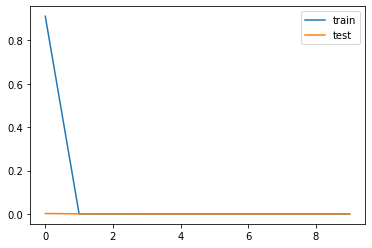

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task1.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task1.h5")
print("Saved model to disk")

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592/Models
Saved model to disk


accuracy =  1.0
confusion matrix = 
[[10000     0]
 [    0  8000]]


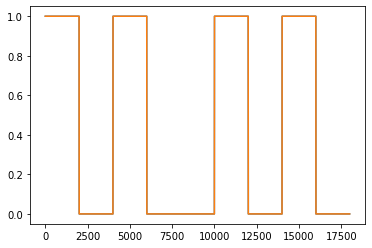

In [ ]:
y_prob=model.predict(test_x)
predicted_y = y_prob.argmax(axis=-1)
plt.plot(test_y)
plt.plot(predicted_y)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_y, predicted_y))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ") 
print(confusion_matrix(test_y, predicted_y))

Hyperparameters adjusted included number of convolutional layers, convolutional kernel size, stride shape, final dense layer output shape, and loss function.
Settled on two convolutional layers (good trade-off between number of parameters (single convolutional layer results in too many parameters) and maintaining information (not over-convolving)), a kernel which has the same length/width ratio as the input image for the first layer and square/equal for the second, a stride equal to the kernel in the first layer, and a final dense layer containing 25 neurons using categorical cross entropy as loss. Also successful in using a single neuron in final dense layer when using binary cross entropy as loss, although this model is not shown/contained in the notebook, since it was no better or worse than this model.

Model was able to accurately predict training, validation, and test data sets without error.

# Task 1 Reduced Dataset and 2D CNN Modeling, Simpler CNN Architecture

The model trained and evaluated in this section has fewer parameters than the preceding model and is trained on a smaller subset of data.

In [ ]:
test_set_x = combustion_img_13['test_set_x']
# (18000,25000) - appears to be 18000 images
test_set_y = combustion_img_13['test_set_y']
# (18000,) - single array of 18000 entrys; assume stable = 1, unstable = 0
train_set_x = combustion_img_13['train_set_x']
# (54000,25000) - appears to be 54000 images
train_set_y = combustion_img_13['train_set_y']
# (54000,) - single array of 54000 entrys; assume stable = 1, unstable = 0
valid_set_x = combustion_img_13['valid_set_x']
# (9000,25000) - appears to be 9000 images
valid_set_y = combustion_img_13['valid_set_y']
# (9000,) - single array of 9000 entrys; assume stable = 1, unstable = 0

In [ ]:
# Create shorter train and validation sets to avoid RAM issues and also to
#evaluate whether a model can be accurate with less than half of the training data

#Method to reduce sets is to identify transitions between stability and instability in the
#provided data sets, then select a fixed window around the transition
#This ensures equal representation of the two classes (stable and unstable)
train_window=2450
valid_window=400
train_transitions=np.where(train_set_y[:-1] != train_set_y[1:])[0]+1
test_transitions=np.where(test_set_y[:-1] != test_set_y[1:])[0]+1
valid_transitions=np.where(valid_set_y[:-1] != valid_set_y[1:])[0]+1
reduced_train_set_x=[]
reduced_train_set_y=[]
reduced_test_set_x=[]
reduced_test_set_y=[]
reduced_valid_set_x=[]
reduced_valid_set_y=[]

for k in np.arange(0,len(train_transitions)):
  if k==0:
    reduced_train_set_x=train_set_x[train_transitions[k]-int(train_window/2):train_transitions[k]+int(train_window/2),:]
    reduced_train_set_y=train_set_y[train_transitions[k]-int(train_window/2):train_transitions[k]+int(train_window/2),]
  else:
    reduced_train_set_x=np.concatenate((reduced_train_set_x,train_set_x[train_transitions[k]-int(train_window/2):train_transitions[k]+int(train_window/2),:]))
    reduced_train_set_y=np.concatenate((reduced_train_set_y,train_set_y[train_transitions[k]-int(train_window/2):train_transitions[k]+int(train_window/2),]))

reduced_test_set_x=test_set_x
reduced_test_set_y=test_set_y

for k in np.arange(0,len(valid_transitions)):
  if k==0:
    reduced_valid_set_x=valid_set_x[valid_transitions[k]-int(valid_window/2):valid_transitions[k]+int(valid_window/2),:]
    reduced_valid_set_y=valid_set_y[valid_transitions[k]-int(valid_window/2):valid_transitions[k]+int(valid_window/2),]
  else:
    reduced_valid_set_x=np.concatenate((reduced_valid_set_x,valid_set_x[valid_transitions[k]-int(valid_window/2):valid_transitions[k]+int(valid_window/2),:]))
    reduced_valid_set_y=np.concatenate((reduced_valid_set_y,valid_set_y[valid_transitions[k]-int(valid_window/2):valid_transitions[k]+int(valid_window/2),]))

print(reduced_train_set_y.shape)
print(reduced_valid_set_y.shape)
print(reduced_test_set_y.shape)

(17150,)
(2800,)
(18000,)


In [ ]:
# Create arrays of images
# the array should be (XXX, 250, 100, 1)
# Each image is a 25000 length array. Since the images are 250 x 100, it is
# assumed that the images are grayscale. 
# Resource: https://www.geeksforgeeks.org/convert-a-numpy-array-to-an-image/?msclkid=66a28f83b67911ec9454a31c9393e7bb

# Define a function to do this
def create_image(array):

  # Reshape array into desired resolution
  array = np.reshape(array, (250,100))
  return array

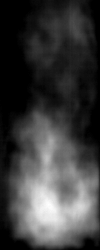

In [ ]:
# Test to make sure the image looks correct
array = np.reshape(test_set_x[1], (250,100))
image = im.fromarray(array)
image

In [ ]:
# Create arrays of images (x arrays)
# Initialize arrays, each should be (XXX, 250, 100, 1)
# Use float32 to save RAM

test_x = np.float32(np.empty((len(reduced_test_set_x),250,100)))
valid_x = np.float32(np.empty((len(reduced_valid_set_x),250,100)))
train_x = np.float32(np.empty((len(reduced_train_set_x),250,100)))

In [ ]:
#reshape arrays into desired resolution and rescale pixel intensities such that
#they are between 0 and 1
for k in range(len(reduced_test_set_x)):
  array = create_image(reduced_test_set_x[k])
  test_x[k] = array/255

for k in range(len(reduced_valid_set_x)):
  array = create_image(reduced_valid_set_x[k])
  valid_x[k] = array/255

for k in range(len(reduced_train_set_x)):
  array = create_image(reduced_train_set_x[k])
  train_x[k] = array/255

test_y=reduced_test_set_y
valid_y=reduced_valid_set_y
train_y=reduced_train_set_y

In [ ]:
# check shape to make sure it is as expected
print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(18000, 250, 100)
(18000,)
(17150, 250, 100)
(17150,)
(2800, 250, 100)
(2800,)


In [ ]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv2D(25, (5, 2), strides=(5, 2),padding="same",activation='relu', input_shape=(250, 100, 1)),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Conv2D(50, (2, 2), activation='relu'),
            tf.keras.layers.MaxPooling2D((2, 2)),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(1, activation='sigmoid')                
          ])
  model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 50, 50, 25)        275       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 25, 25, 25)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 50)        5050      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 12, 12, 50)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 7200)              0         
                                                                 
 dense (Dense)               (None, 1)                 7

In [ ]:
#train_x=np.reshape(train_x,(54000,250,100,1))
#train_y=np.reshape(train_y,(54000,1))
train_x=np.reshape(train_x,(len(train_transitions)*train_window,250,100,1))
train_y=np.reshape(train_y,(len(train_transitions)*train_window,1))

test_x=np.reshape(test_x,(18000,250,100,1))
test_y=np.reshape(test_y,(18000,1))

valid_x=np.reshape(valid_x,(len(valid_transitions)*valid_window,250,100,1))
valid_y=np.reshape(valid_y,(len(valid_transitions)*valid_window,1))

print(test_x.shape)
print(test_y.shape)
print(train_x.shape)
print(train_y.shape)
print(valid_x.shape)
print(valid_y.shape)

(18000, 250, 100, 1)
(18000, 1)
(17150, 250, 100, 1)
(17150, 1)
(2800, 250, 100, 1)
(2800, 1)


In [ ]:
history = model.fit(train_x, train_y, epochs=20,batch_size=256,validation_data=(valid_x, valid_y),verbose=2)

Epoch 1/20
67/67 - 14s - loss: 0.2069 - accuracy: 0.9304 - val_loss: 0.3630 - val_accuracy: 0.9286 - 14s/epoch - 204ms/step
Epoch 2/20
67/67 - 2s - loss: 0.0689 - accuracy: 0.9843 - val_loss: 0.1565 - val_accuracy: 0.9464 - 2s/epoch - 26ms/step
Epoch 3/20
67/67 - 2s - loss: 0.0279 - accuracy: 0.9932 - val_loss: 0.0591 - val_accuracy: 0.9693 - 2s/epoch - 26ms/step
Epoch 4/20
67/67 - 2s - loss: 0.0121 - accuracy: 0.9967 - val_loss: 0.0340 - val_accuracy: 0.9821 - 2s/epoch - 26ms/step
Epoch 5/20
67/67 - 2s - loss: 0.0057 - accuracy: 0.9990 - val_loss: 0.0115 - val_accuracy: 0.9982 - 2s/epoch - 26ms/step
Epoch 6/20
67/67 - 2s - loss: 0.0028 - accuracy: 0.9998 - val_loss: 0.0049 - val_accuracy: 1.0000 - 2s/epoch - 25ms/step
Epoch 7/20
67/67 - 2s - loss: 0.0019 - accuracy: 0.9998 - val_loss: 0.0033 - val_accuracy: 1.0000 - 2s/epoch - 26ms/step
Epoch 8/20
67/67 - 2s - loss: 0.0014 - accuracy: 0.9999 - val_loss: 0.0026 - val_accuracy: 1.0000 - 2s/epoch - 35ms/step
Epoch 9/20
67/67 - 2s - loss:

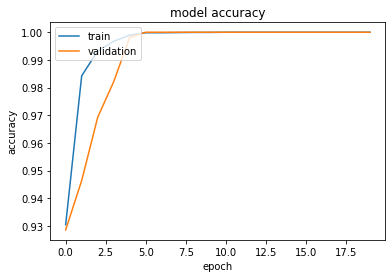

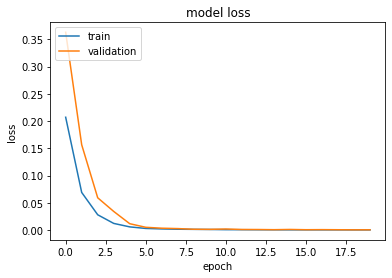

In [ ]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task1_reduced.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task1_reduced.h5")
print("Saved model to disk")

/content/drive/MyDrive/ME592/Models
Saved model to disk


In [ ]:
reduced_test_set_x=[]
reduced_test_set_y=[]
reduced_train_set_x=[]
reduced_train_set_y=[]
reduced_validation_set_x=[]
reduced_validation_set_y=[]
test_set_x=[]
test_set_y=[]
train_set_x=[]
train_set_y=[]
valid_set_x=[]
valid_set_y=[]
history=[]
combustion_img_13=[]
array=[]

<function matplotlib.pyplot.show>

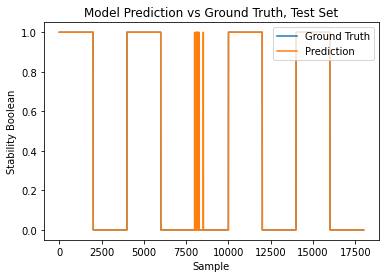

In [ ]:
#Test the model by evaluating the third data set, "test"
test_y_pred=np.rint(model.predict(test_x))
plt.plot(test_y)
plt.plot(test_y_pred)
plt.xlabel('Sample')
plt.ylabel('Stability Boolean')
plt.legend(['Ground Truth', 'Prediction'], loc='upper right')
plt.title('Model Prediction vs Ground Truth, Test Set')
plt.show

In [ ]:
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_y, test_y_pred))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ") 
print(confusion_matrix(test_y, test_y_pred))

accuracy =  0.9975555555555555
confusion matrix = 
[[9956   44]
 [   0 8000]]


## Discussion

The model shown in "Task 1 Complete Dataset and 2D CNN Modeling" has a large number of tuning parameters and was trained on the entire 54,000 point training data set.

This model was trained on 17,150 points (instead of 54,000), and it contains 12,526 parameters (instead of 741,975) after adjusting the structure of the CNN. Both of these contribute to much faster training time at the expense of ~0.25% accuracy loss (100% accuracy for the full data set trained more complex model, 99.75% accuracy for this simpler model trained on fewer data points).



# Task 2

## Stacking Images

In [ ]:
train_set_x = train_x
train_set_y = train_y
valid_set_x = valid_x
valid_set_y = valid_y
test_set_x = test_x
test_set_y = test_y

In [ ]:
import tensorflow as tf
for i in [16]: #[4, 8, 12, 16]:
  train_set_x_3d = []
  train_set_y_3d=[]

  for z in range(0,len(train_set_x),i):
    RGB = np.dstack((train_set_x[z:z+i]))
    train_set_x_3d.append(RGB)
    train_set_y_3d.append(train_set_y[z+i-1])

  train_set_x_3d=np.array(train_set_x_3d)
  train_set_y_3d=np.array(train_set_y_3d)

  train_set_x_3d = tf.expand_dims(train_set_x_3d, axis=4)
  print(train_set_x_3d.shape)

  valid_set_x_3d = []
  valid_set_y_3d = []

  for z in range(0,len(valid_set_x)-8,i):
    RGB = np.dstack((valid_set_x[z:z+i]))
    valid_set_x_3d.append(RGB)
    valid_set_y_3d.append(valid_set_y[z+i-1])

  valid_set_x_3d=np.array(valid_set_x_3d)
  valid_set_y_3d=np.array(valid_set_y_3d)

  valid_set_x_3d = tf.expand_dims(valid_set_x_3d, axis=4)
  print(valid_set_x_3d.shape)

  test_set_x_3d = []
  test_set_y_3d = []

  for z in range(0,len(test_set_x),i):
    RGB = np.dstack((test_set_x[z:z+i]))
    test_set_x_3d.append(RGB)
    test_set_y_3d.append(test_set_y[z+i-1])

  test_set_x_3d=np.array(test_set_x_3d)
  test_set_y_3d=np.array(test_set_y_3d)

  test_set_x_3d = tf.expand_dims(test_set_x_3d, axis=4)
  print(test_set_x_3d.shape)


  np.save("train_set_"+str(i)+"_x_3d.npy",train_set_x_3d)
  np.save("train_set_"+str(i)+"_y_3d.npy",train_set_y_3d)

  np.save("valid_set_"+str(i)+"_x_3d.npy",valid_set_x_3d)
  np.save("valid_set_"+str(i)+"_y_3d.npy",valid_set_y_3d)

  np.save("test_set_"+str(i)+"_x_3d.npy",test_set_x_3d)
  np.save("test_set_"+str(i)+"_y_3d.npy",test_set_y_3d)

(3375, 250, 100, 16, 1)
(562, 250, 100, 16, 1)
(1125, 250, 100, 16, 1)


In [ ]:
import numpy as np
import cv2
# from google.colab.patches import cv2_imshow
import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv3D, MaxPooling3D, Dropout, BatchNormalization
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn import utils

## Stacked Images N = 4 3D CNN

In [ ]:
train_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_4_x_3d.npy")
train_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_4_y_3d.npy")

valid_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_4_x_3d.npy")
valid_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_4_y_3d.npy")

test_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_4_x_3d.npy")
test_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_4_y_3d.npy")

In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu',input_shape=(250, 100, 4, 1)),
            tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
            tf.keras.layers.BatchNormalization(center=True, scale=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')                
          ])
  #adam = keras.optimizers.Adam(learning_rate=0.001)
  #model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 248, 98, 2, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 124, 49, 1, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 124, 49, 1, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 124, 49, 1, 32)    0         
                                                                 
 flatten (Flatten)           (None, 194432)            0         
                                                                 
 dense (Dense)               (None, 256)               4

In [ ]:
train_set_x_3d , train_set_y_3d = utils.shuffle(train_set_x_3d, train_set_y_3d)
valid_set_x_3d , valid_set_y_3d = utils.shuffle(valid_set_x_3d, valid_set_y_3d)

In [ ]:
history = model.fit(train_set_x_3d, train_set_y_3d, epochs=5,batch_size=128,validation_data=(valid_set_x_3d, valid_set_y_3d),verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


106/106 [==============================] - 25s 198ms/step - loss: 2.0997 - accuracy: 0.9593 - val_loss: 0.2616 - val_accuracy: 0.9627
Epoch 2/5
106/106 [==============================] - 20s 185ms/step - loss: 2.3841e-04 - accuracy: 0.9999 - val_loss: 0.0238 - val_accuracy: 0.9871
Epoch 3/5
106/106 [==============================] - 20s 184ms/step - loss: 0.0022 - accuracy: 0.9998 - val_loss: 0.0063 - val_accuracy: 0.9987
Epoch 4/5
106/106 [==============================] - 20s 186ms/step - loss: 9.8331e-06 - accuracy: 1.0000 - val_loss: 1.0661e-04 - val_accuracy: 1.0000
Epoch 5/5
106/106 [==============================] - 20s 185ms/step - loss: 6.1514e-06 - accuracy: 1.0000 - val_loss: 3.7803e-05 - val_accuracy: 1.0000


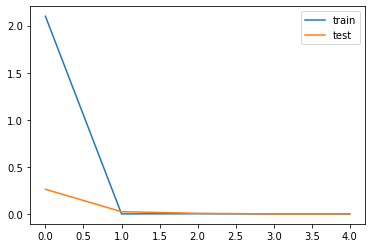

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task2_N4.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task2_N4.h5")
print("Saved model to disk")

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592/Models
Saved model to disk


accuracy =  1.0
confusion matrix = 
[[2500    0]
 [   0 2000]]


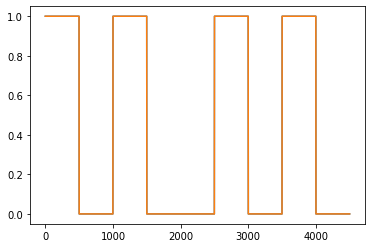

In [ ]:
y_prob=model.predict(test_set_x_3d)
predicted_y_3d = y_prob.argmax(axis=-1)
plt.plot(test_set_y_3d)
plt.plot(predicted_y_3d)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_set_y_3d, predicted_y_3d))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ")
print(confusion_matrix(test_set_y_3d, predicted_y_3d))

## Stacked Images N = 8 3D CNN

In [ ]:
train_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_8_x_3d.npy")
train_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_8_y_3d.npy")

valid_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_8_x_3d.npy")
valid_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_8_y_3d.npy")

test_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_8_x_3d.npy")
test_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_8_y_3d.npy")

In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu',input_shape=(250, 100, 8, 1)),
            tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
            tf.keras.layers.BatchNormalization(center=True, scale=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')                
          ])
  #adam = keras.optimizers.Adam(learning_rate=0.001)
  #model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 248, 98, 6, 32)    896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 124, 49, 3, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 124, 49, 3, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 124, 49, 3, 32)    0         
                                                                 
 flatten (Flatten)           (None, 583296)            0         
                                                                 
 dense (Dense)               (None, 256)               1

In [ ]:
train_set_x_3d , train_set_y_3d = utils.shuffle(train_set_x_3d, train_set_y_3d)
valid_set_x_3d , valid_set_y_3d = utils.shuffle(valid_set_x_3d, valid_set_y_3d)

In [ ]:
history = model.fit(train_set_x_3d, train_set_y_3d, epochs=5,batch_size=32,validation_data=(valid_set_x_3d, valid_set_y_3d),verbose=1)

Epoch 1/5


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


211/211 [==============================] - 39s 172ms/step - loss: 0.7437 - accuracy: 0.9941 - val_loss: 1.7067 - val_accuracy: 0.9831
Epoch 2/5
211/211 [==============================] - 35s 168ms/step - loss: 0.3424 - accuracy: 0.9975 - val_loss: 14.7161 - val_accuracy: 0.8800
Epoch 3/5
211/211 [==============================] - 35s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/5
211/211 [==============================] - 35s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/5
211/211 [==============================] - 35s 167ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000


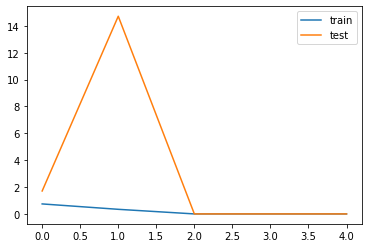

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task2_N8.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task2_N8.h5")
print("Saved model to disk")

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592/Models
Saved model to disk


accuracy =  1.0
confusion matrix = 
[[1250    0]
 [   0 1000]]


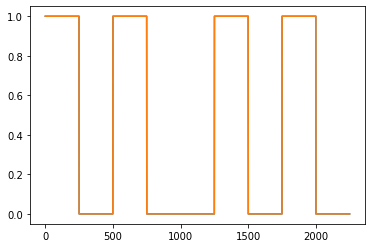

In [ ]:
y_prob=model.predict(test_set_x_3d)
predicted_y_3d = y_prob.argmax(axis=-1)
plt.plot(test_set_y_3d)
plt.plot(predicted_y_3d)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_set_y_3d, predicted_y_3d))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ")
print(confusion_matrix(test_set_y_3d, predicted_y_3d))

## Stacked Images N=12 3D CNN

In [ ]:
train_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_12_x_3d.npy")
train_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_12_y_3d.npy")

valid_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_12_x_3d.npy")
valid_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_12_y_3d.npy")

test_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_12_x_3d.npy")
test_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_12_y_3d.npy")

In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu',input_shape=(250, 100, 12, 1)),
            tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
            tf.keras.layers.BatchNormalization(center=True, scale=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')                
          ])
  #adam = keras.optimizers.Adam(learning_rate=0.001)
  #model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 248, 98, 10, 32)   896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 124, 49, 5, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 124, 49, 5, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 124, 49, 5, 32)    0         
                                                                 
 flatten (Flatten)           (None, 972160)            0         
                                                                 
 dense (Dense)               (None, 256)               2

In [ ]:
train_set_x_3d , train_set_y_3d = utils.shuffle(train_set_x_3d, train_set_y_3d)
valid_set_x_3d , valid_set_y_3d = utils.shuffle(valid_set_x_3d, valid_set_y_3d)

In [ ]:
history = model.fit(train_set_x_3d, train_set_y_3d, epochs=8,batch_size=32,validation_data=(valid_set_x_3d, valid_set_y_3d),verbose=1)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


141/141 [==============================] - 29s 180ms/step - loss: 4.8795 - accuracy: 0.9867 - val_loss: 44.1017 - val_accuracy: 0.9960
Epoch 2/8
141/141 [==============================] - 24s 171ms/step - loss: 0.2099 - accuracy: 0.9991 - val_loss: 45.9625 - val_accuracy: 0.9960
Epoch 3/8
141/141 [==============================] - 24s 171ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 60.3398 - val_accuracy: 0.9960
Epoch 4/8
141/141 [==============================] - 24s 171ms/step - loss: 0.5290 - accuracy: 0.9984 - val_loss: 52.4538 - val_accuracy: 0.9947
Epoch 5/8
141/141 [==============================] - 24s 171ms/step - loss: 0.5930 - accuracy: 0.9987 - val_loss: 346.5296 - val_accuracy: 0.7973
Epoch 6/8
141/141 [==============================] - 24s 171ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 72.9365 - val_accuracy: 0.9960
Epoch 7/8
141/141 [==============================] - 24s 171ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 78.5743 - val

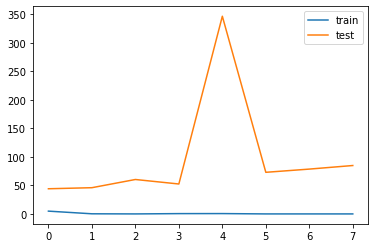

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task2_N12.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task2_N12.h5")
print("Saved model to disk")

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592/Models
Saved model to disk


accuracy =  0.998
confusion matrix = 
[[830   3]
 [  0 667]]


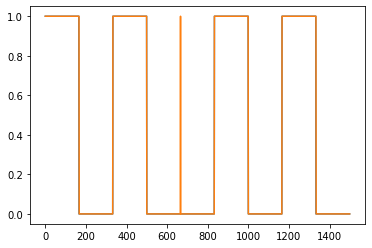

In [ ]:
y_prob=model.predict(test_set_x_3d)
predicted_y_3d = y_prob.argmax(axis=-1)
plt.plot(test_set_y_3d)
plt.plot(predicted_y_3d)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_set_y_3d, predicted_y_3d))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ")
print(confusion_matrix(test_set_y_3d, predicted_y_3d))

In [ ]:
history = model.fit(train_set_x_3d, train_set_y_3d, epochs=10,batch_size=32,validation_data=(valid_set_x_3d, valid_set_y_3d),verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


141/141 [==============================] - 36s 181ms/step - loss: 1.9288 - accuracy: 0.9889 - val_loss: 34.7442 - val_accuracy: 0.9507
Epoch 2/10
141/141 [==============================] - 24s 172ms/step - loss: 1.6809e-04 - accuracy: 0.9998 - val_loss: 48.7901 - val_accuracy: 0.9933
Epoch 3/10
141/141 [==============================] - 24s 172ms/step - loss: 0.0535 - accuracy: 0.9982 - val_loss: 54.9184 - val_accuracy: 0.9960
Epoch 4/10
141/141 [==============================] - 24s 172ms/step - loss: 0.1137 - accuracy: 0.9989 - val_loss: 43.5995 - val_accuracy: 0.9960
Epoch 5/10
141/141 [==============================] - 24s 172ms/step - loss: 0.5904 - accuracy: 0.9962 - val_loss: 33.0896 - val_accuracy: 0.9960
Epoch 6/10
141/141 [==============================] - 24s 172ms/step - loss: 0.8399 - accuracy: 0.9971 - val_loss: 22.2605 - val_accuracy: 0.9933
Epoch 7/10
141/141 [==============================] - 24s 172ms/step - loss: 0.4539 - accuracy: 0.9982 - val_loss: 53.5066 - val_ac

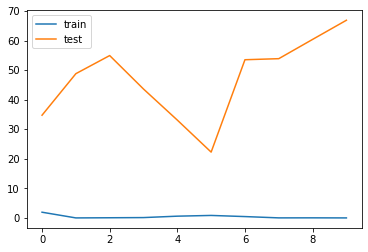

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

accuracy =  0.998
confusion matrix = 
[[830   3]
 [  0 667]]


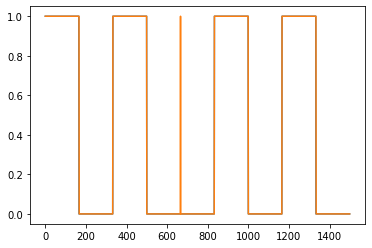

In [ ]:
y_prob=model.predict(test_set_x_3d)
predicted_y_3d = y_prob.argmax(axis=-1)
plt.plot(test_set_y_3d)
plt.plot(predicted_y_3d)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_set_y_3d, predicted_y_3d))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ")
print(confusion_matrix(test_set_y_3d, predicted_y_3d))

## Stacked Images N=16 3D CNN

In [ ]:
train_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_16_x_3d.npy")
train_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/train_set_16_y_3d.npy")

valid_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_16_x_3d.npy")
valid_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/valid_set_16_y_3d.npy")

test_set_x_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_16_x_3d.npy")
test_set_y_3d = np.load("/content/drive/MyDrive/ME592/3D CNN files/test_set_16_y_3d.npy")

In [ ]:
def create_model():
  model= tf.keras.Sequential([
            tf.keras.layers.Conv3D(32, kernel_size=(3, 3, 3), activation='relu',input_shape=(250, 100, 16, 1)),
            tf.keras.layers.MaxPooling3D(pool_size=(2, 2, 2)),
            tf.keras.layers.BatchNormalization(center=True, scale=True),
            tf.keras.layers.Dropout(0.5),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(256, activation='relu'),
            tf.keras.layers.Dense(2, activation='softmax')                
          ])
  #adam = keras.optimizers.Adam(learning_rate=0.001)
  #model.compile(loss='binary_crossentropy',optimizer='sgd',metrics=['accuracy'])
  model.compile(optimizer='adam',loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['accuracy'])

  return model

with tf.device('/device:GPU:0'):
#with tpu_strategy.scope():
  model = create_model()

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 248, 98, 14, 32)   896       
                                                                 
 max_pooling3d (MaxPooling3D  (None, 124, 49, 7, 32)   0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 124, 49, 7, 32)   128       
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 124, 49, 7, 32)    0         
                                                                 
 flatten (Flatten)           (None, 1361024)           0         
                                                                 
 dense (Dense)               (None, 256)               3

In [ ]:
train_set_x_3d , train_set_y_3d = utils.shuffle(train_set_x_3d, train_set_y_3d)
valid_set_x_3d , valid_set_y_3d = utils.shuffle(valid_set_x_3d, valid_set_y_3d)

In [ ]:
history = model.fit(train_set_x_3d, train_set_y_3d, epochs=8,batch_size=16,validation_data=(valid_set_x_3d, valid_set_y_3d),verbose=1)

Epoch 1/8


/usr/local/lib/python3.7/dist-packages/tensorflow/python/util/dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


211/211 [==============================] - 48s 178ms/step - loss: 7.5793 - accuracy: 0.9819 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 2/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0035 - accuracy: 0.9997 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 3/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 4/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 5/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 6/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000 - val_loss: 0.0000e+00 - val_accuracy: 1.0000
Epoch 7/8
211/211 [==============================] - 36s 172ms/step - loss: 0.0000e+00 - accuracy: 1.0000 

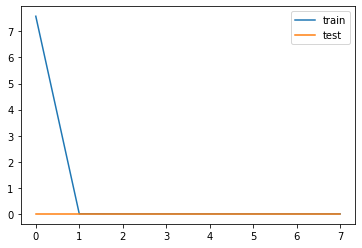

In [ ]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show() 

In [ ]:
%cd /content/drive/MyDrive/ME592/Models
# serialize model to JSON
model_json = model.to_json()
with open("model_task2_N16.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("model_task2_N16.h5")
print("Saved model to disk")

/content/drive/.shortcut-targets-by-id/14A9iw12Bc8xWO_3nrziSGEk1uDWkLJ3b/ME592/Models
Saved model to disk


In [ ]:
# Loads the weights
model.load_weights('/content/drive/MyDrive/ME592/Models/model_task2_N16.h5')

accuracy =  1.0
confusion matrix =  [[625   0]
 [  0 500]]


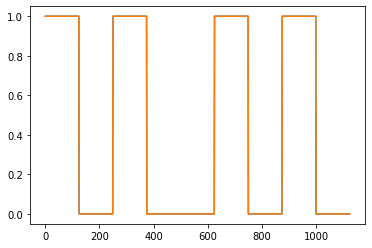

In [ ]:
y_prob=model.predict(test_set_x_3d)
predicted_y_3d = y_prob.argmax(axis=-1)
plt.plot(test_set_y_3d)
plt.plot(predicted_y_3d)
# check_acc=(test_y,np.round(predicted_y/100,0))
# acc=np.sum(check_acc)/len(test_y)
plt.show
#print(acc)
from sklearn.metrics import accuracy_score
print("accuracy = ", accuracy_score(test_set_y_3d, predicted_y_3d))
from sklearn.metrics import confusion_matrix
print("confusion matrix = ", confusion_matrix(test_set_y_3d, predicted_y_3d))

## Discussion
In Task 2 we trained our 3D CNN model with a stack of images labelled stable or unstable. The stack consisted of different number of images and 4 set of trained 3D CNN models were evaluated. Our overall observation was that with values N = 4,8,16 the model was trained well and the training and validation losses were observed to converge. Testing on the stacked test data also resulted in very high accuracy ~100% with all the stacks being correctly classified. Only in the case of N=12, even with different parameters, the validation loss did not seem to converge. Yet the model's prediction accuracy was relatively high ~99%. 